Train features shape: (39073, 1, 7, 7)
Validation features shape: (9769, 1, 7, 7)

--- Running Adam optimizer ---

--- Running Nadam optimizer ---
  Optimizer                                         Train Loss  \
0      Adam  [1.0093948774889623, 0.9977949967301475, 0.995...   
1     Nadam  [1.0085174568454907, 0.9993571131034079, 0.992...   

                                      Train Accuracy  \
0  [0.784403552325135, 0.7909297980702787, 0.7894...   
1  [0.7840964348783047, 0.7868348987792082, 0.794...   

                                            Val Loss  \
0  [1.1984514311033794, 0.9927656295807411, 1.207...   
1  [1.0129841194144047, 1.0919804780018807, 0.987...   

                                        Val Accuracy  Final Validation Loss  \
0  [0.2879516838980448, 0.8013102671716654, 0.294...               1.162680   
1  [0.73190705292251, 0.5232879516838981, 0.79813...               0.956708   

   Final Validation Accuracy  Convergence Time (s)  Final Training Loss  \
0  

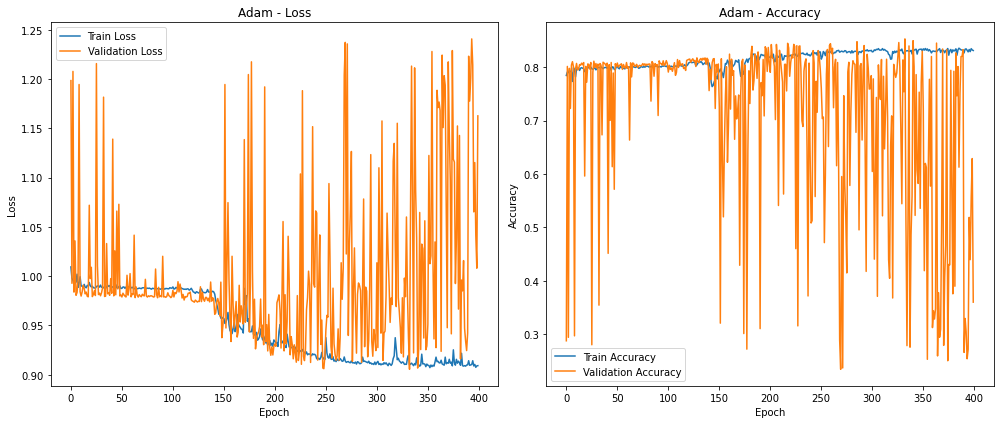


Optimizer: Nadam
Final Training Loss: 0.9146
Final Training Accuracy: 0.8251
Final Validation Loss: 0.9567
Final Validation Accuracy: 0.7158
Time taken: 2330.60 seconds


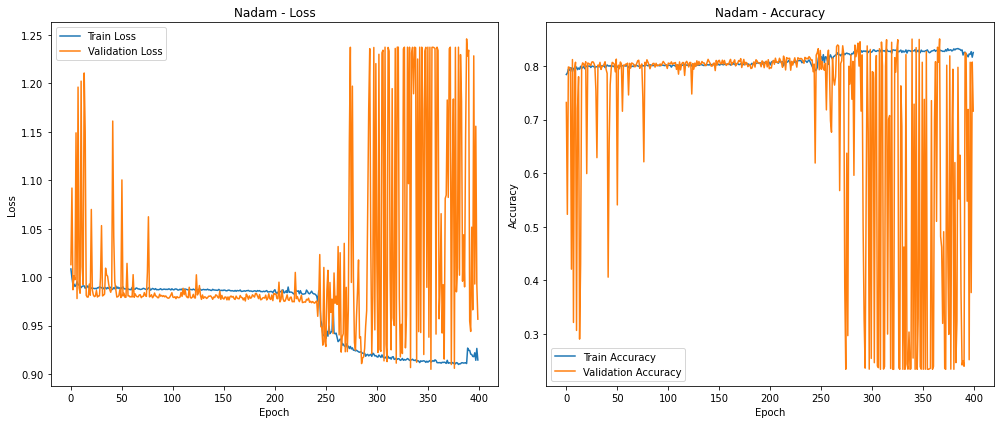

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from tabulate import tabulate

# Carica i dati
train_features = np.load('dataset/train_features.npy')
val_features = np.load('dataset/test_features.npy')
train_labels = np.load('dataset/train_labels.npy')
val_labels = np.load('dataset/test_labels.npy')

# Trasponi le dimensioni per adattarle alla CNN
train_features = np.transpose(train_features, (0, 3, 1, 2))  # (31258, 7, 7, 1) -> (31258, 1, 7, 7)
val_features = np.transpose(val_features, (0, 3, 1, 2))  # (N, 7, 7, 1) -> (N, 1, 7, 7)

# Calcolo della distribuzione delle classi
class_counts = np.bincount(train_labels)
majority_class_count = max(class_counts)
class_weights = majority_class_count / class_counts
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Verifica le forme
print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

# Dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)  # Modificato a float

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Creazione dei dataset
train_dataset = CustomDataset(train_features, train_labels)
val_dataset = CustomDataset(val_features, val_labels)

# Creazione dei dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Definizione della rete CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, 1)  # Modificato per avere 1 output

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = x.view(-1, 128 * 1 * 1)  # Flatten
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Applicare la sigmoide
        return x

# Funzione di training
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    corrects = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)  # Modificato per la BCE
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs.view(-1) > 0.5).float()  # Predizioni binarie
        corrects += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = corrects / total
    return epoch_loss, epoch_accuracy

# Funzione di valutazione
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)  # Modificato per la BCE
            preds = (outputs.view(-1) > 0.5).float()  # Predizioni binarie
            corrects += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = corrects / total
    return epoch_loss, accuracy

learning_rate = 0.001

# Esperimento con diversi ottimizzatori e pesi di classe
def experiment_with_optimizers(train_loader, val_loader, num_epochs=400, device='cpu'):
    optimizers = {
#         "SGD": optim.SGD
#         "SGD+Momentum": lambda params: optim.SGD(params, lr=0.001, momentum=0.9),  # Aggiunta
#         "AdaGrad": optim.Adagrad,
#         "AdaDelta": optim.Adadelta,
#         "RMSProp": optim.RMSprop,
        "Adam": optim.Adam,
#         "Adamax": optim.Adamax,   
        "Nadam": optim.NAdam
    }

    
    results = []

    for opt_name, opt_class in optimizers.items():
        print(f"\n--- Running {opt_name} optimizer ---")
        model = SimpleCNN().to(device)
        if opt_class:
            optimizer = opt_class(model.parameters(), lr=learning_rate)
        else:
            continue

        # Aggiungi pesi di classe alla loss function
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1].to(device))  # Modificato per BCE

        start_time = time.time()

        current_results = {
            "Optimizer": opt_name,
            "Train Loss": [],
            "Train Accuracy": [],
            "Val Loss": [],
            "Val Accuracy": [],
            "Final Validation Loss": 0,
            "Final Validation Accuracy": 0,
            "Convergence Time (s)": 0
        }

        for epoch in range(num_epochs):
            train_loss, train_accuracy = train_model(model, train_loader, criterion, optimizer, device)
            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

            current_results["Train Loss"].append(train_loss)
            current_results["Train Accuracy"].append(train_accuracy)
            current_results["Val Loss"].append(val_loss)
            current_results["Val Accuracy"].append(val_accuracy)

            current_results["Final Validation Loss"] = val_loss
            current_results["Final Validation Accuracy"] = val_accuracy
            # Aggiorna il dizionario dei risultati all'interno del ciclo per ogni epoca
            current_results["Final Training Loss"] = train_loss
            current_results["Final Training Accuracy"] = train_accuracy


        elapsed_time = time.time() - start_time
        current_results["Convergence Time (s)"] = elapsed_time

        results.append(current_results)

    results_df = pd.DataFrame(results)
    print(results_df)
    return results

# Funzione per stampare i risultati
def print_results_table(results):
    df = pd.DataFrame(results)
    print(tabulate(df, headers='keys', tablefmt='pretty'))

# Imposta il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Esegui l'esperimento con pesi di classe
results = experiment_with_optimizers(train_loader, val_loader, num_epochs=400, device=device)

# Stampa la tabella dei risultati
print_results_table(results)

# Analisi dei risultati e tracciamento dei grafici
for result in results:
    opt_name = result['Optimizer']
    val_loss = result['Final Validation Loss']
    val_accuracy = result['Final Validation Accuracy']
    train_loss = result['Final Training Loss'] 
    train_accuracy = result['Final Training Accuracy']  
    convergence_time = result['Convergence Time (s)']

    print(f"\nOptimizer: {opt_name}")
    print(f"Final Training Loss: {train_loss:.4f}")
    print(f"Final Training Accuracy: {train_accuracy:.4f}")
    print(f"Final Validation Loss: {val_loss:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy:.4f}")
    print(f"Time taken: {convergence_time:.2f} seconds")

    # Tracciare i grafici della perdita e dell'accuratezza
    plt.figure(figsize=(14, 6))

    # Grafico della perdita
    plt.subplot(1, 2, 1)
    plt.plot(result['Train Loss'], label='Train Loss')
    plt.plot(result['Val Loss'], label='Validation Loss')
    plt.title(f'{opt_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Grafico dell'accuratezza
    plt.subplot(1, 2, 2)
    plt.plot(result['Train Accuracy'], label='Train Accuracy')
    plt.plot(result['Val Accuracy'], label='Validation Accuracy')
    plt.title(f'{opt_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{opt_name}_performance.png")
    plt.show()
